### LangGraph 多智能体协作中文指南

在单个领域中，通常一个智能体能够有效地使用一些工具，但即使是使用强大的模型（例如 GPT-4），它在使用大量工具时效果可能会有所降低。

一种解决复杂任务的方法是采用“分而治之”的方式：为每个任务或领域创建一个专门的智能体，并将任务路由到正确的“专家”。

本指南灵感来自 Wu 等人的论文《AutoGen: 通过多智能体对话实现下一代 LLM 应用》 展示了使用 LangGraph 进行多智能体协作的一种方法。

最终的图表看起来可能像下图所示：

![simple_multi_agent_diagram](https://langchain-ai.github.io/langgraph/tutorials/multi_agent/img/simple_multi_agent_diagram.png)

#### 说明

**经过多次测试，多智能体仅在 `gpt-4o` 上成功运行**。见指南最后的 **GPT-4o 模型生成结果** 章节。

当切换为 `gpt-4o-mini` 时，模型表现为无法成功调用 `Python REPL 工具执行代码`，但可以生成对应的 Python 代码。


In [1]:
%%capture --no-stderr
%pip install langchain langchain_openai langsmith pandas langchain_experimental matplotlib langgraph langchain_core

In [2]:
import getpass
import os

# 定义一个帮助函数来检查环境变量，如果不存在则提示用户输入
def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"请输入您的 {var}")

# 设置 OpenAI 和 Langchain API 密钥
# _set_if_undefined("OPENAI_API_KEY")
# _set_if_undefined("LANGCHAIN_API_KEY")
# _set_if_undefined("TAVILY_API_KEY")

# 可选：在 LangSmith 中添加追踪功能
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Multi-agent Collaboration"



### 创建智能体

以下助手函数将帮助我们创建智能体。这些智能体将成为图中的节点。

#### 注释说明：
- 该函数 `create_agent` 用于创建一个智能体，通过为该智能体提供系统消息和可以使用的工具来指定其行为。
- `ChatPromptTemplate.from_messages` 是用于构建该智能体的对话提示模板，系统消息告诉智能体它是如何与其他智能体协作的。
- 提示模板通过 `partial` 函数插入了系统消息和工具名称，使得智能体能够根据提供的工具执行任务。
- 最终，智能体被绑定到所提供的 LLM（大型语言模型）和工具列表中，构成一个完整的智能体逻辑。

In [3]:
from langchain_core.messages import BaseMessage, HumanMessage, ToolMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import END, StateGraph, START


# 创建智能体的函数，绑定 LLM（大型语言模型） 和工具
def create_agent(llm, tools, system_message: str):
    """创建一个智能体。"""
    # 定义智能体的提示模板，包含系统消息和工具信息
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",  # 系统消息部分，描述智能体的行为逻辑
                "你是一个有帮助的 AI 助手，正在与其他助手协作。"
                " 使用提供的工具逐步解决问题。"
                " 如果你无法完全回答，没关系，另一个助手会接手，使用不同的工具继续。"
                " 尽你所能执行操作以取得进展。"
                " 如果你或其他助手有最终答案或可交付物，请在回复中加上 FINAL ANSWER 作为前缀，"
                " 让团队知道可以停止操作。"
                " 你可以使用以下工具：{tool_names}。\n{system_message}",  # 提供的工具名称和系统消息
            ),
            MessagesPlaceholder(variable_name="messages"),  # 用于替换的消息占位符
        ]
    )
    
    # 将系统消息部分和工具名称插入到提示模板中
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    
    # 将提示模板与语言模型和工具绑定
    return prompt | llm.bind_tools(tools)



### 定义工具

接下来我们定义一些未来智能体将使用的工具。

#### 注释说明：
- `tavily_tool`: 定义了一个 Tavily 搜索工具，可以搜索最多 5 条结果。
- `repl`: 定义了一个 Python REPL 工具，用于执行 Python 代码块。
- `python_repl` 函数：这是一个装饰的工具函数，接受 Python 代码作为输入，并通过 `PythonREPL` 环境执行代码。成功执行后返回执行的代码和输出。如果发生错误，则捕获并返回错误信息。


In [4]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

# 定义 Tavily 搜索工具和 Python 代码执行工具
# Tavily 搜索工具，用于搜索最多 5 条结果
tavily_tool = TavilySearchResults(max_results=5)
repl = PythonREPL()

# Python REPL 工具，用于执行 Python 代码
@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        # 如果代码执行失败，返回错误信息
        return f"Failed to execute. Error: {repr(e)}"
    
    # 成功执行的返回信息，包含执行的代码和标准输出
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    
    # 返回结果，并提示如果任务已完成，请回复 FINAL ANSWER
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )


### 创建图

定义工具和辅助函数后，接下来我们将创建各个智能体，并使用 LangGraph 使它们互相通信。

#### 定义状态

我们首先定义图的状态。这将是一个消息列表，并包含一个键来跟踪最近的发送者。

#### 注释说明：
- `AgentState` 是一个 `TypedDict`，它定义了图中传递的状态对象，包括 `messages` 和 `sender`。`messages` 用于存储传递的消息，`sender` 用于跟踪消息的发送者。


In [5]:
import operator
from typing import Annotated, Sequence, TypedDict


# 定义图中传递的对象，包含消息和发送者信息
class AgentState(TypedDict):
    # messages 是传递的消息，使用 Annotated 和 Sequence 来标记类型
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # sender 是发送消息的智能体
    sender: str


#### 定义智能体节点

下面我们定义智能体节点函数（`agent_node`)，然后使用它定义2个智能体节点：
- Researcher
- Chart Generator

#### 注释说明：

- `agent_node` 函数是一个辅助函数，用于创建一个智能体节点。它接受当前的 `state`（状态）、`agent`（智能体） 和 `name`（智能体的名称），并返回一个新的状态字典，包含消息和发送者。
- `research_agent`: 使用 `create_agent` 函数创建了一个研究智能体，使用 `research_llm` 作为语言模型，并且绑定了 `tavily_tool` 搜索工具。
- `chart_agent`: 同样使用 `create_agent` 创建了图表生成器智能体，使用 `chart_llm` 作为语言模型，并绑定了 `python_repl` 代码执行工具。
- `functools.partial`: 用于创建特定名称的智能体节点，例如 `"Researcher"` 和 `"chart_generator"`，并与各自的智能体绑定。

In [6]:
import functools
from langchain_core.messages import AIMessage
from langchain_openai import ChatOpenAI

# 辅助函数：为智能体创建一个节点
def agent_node(state, agent, name):
    # 调用智能体，获取结果
    result = agent.invoke(state)
    
    # 将智能体的输出转换为适合追加到全局状态的格式
    if isinstance(result, ToolMessage):
        pass  # 如果是工具消息，跳过处理
    else:
        # 将结果转换为 AIMessage，并排除部分字段
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
    
    # 返回更新后的状态，包括消息和发送者
    return {
        "messages": [result],  # 包含新生成的消息
        # 我们使用严格的工作流程，通过记录发送者来知道接下来传递给谁
        "sender": name,
    }

In [7]:
# 使用 OpenAI 模型
research_llm =ChatOpenAI(model="gpt-4o-mini")
chart_llm = ChatOpenAI(model="gpt-4o-mini")

In [9]:
# 研究智能体及其节点
research_agent = create_agent(
    research_llm,  # 使用 research_llm 作为研究智能体的语言模型
    [tavily_tool],  # 研究智能体使用 Tavily 搜索工具
    system_message="Before using the search engine, carefully think through and clarify the query. "
    "Then, conduct a single search that addresses all aspects of the query in one go.",  # 系统消息，指导智能体如何使用搜索工具
)
# 使用 functools.partial 创建研究智能体的节点，指定该节点的名称为 "Researcher"
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

In [10]:
# 图表生成器智能体及其节点
chart_agent = create_agent(
    chart_llm,  # 使用 chart_llm 作为图表生成器智能体的语言模型
    [python_repl],  # 图表生成器智能体使用 Python REPL 工具
    system_message="Create clear and user-friendly charts based on the provided data.",  # 系统消息，指导智能体如何生成图表
)
# 使用 functools.partial 创建图表生成器智能体的节点，指定该节点的名称为 "chart_generator"
chart_node = functools.partial(agent_node, agent=chart_agent, name="chart_generator")


#### 定义工具节点

我们现在定义运行工具的节点 `ToolNode` ，将 Tavily 搜索工具和 Python REPL 工具作为一个工具节点，这样可以方便地在工作流中使用这些工具。

In [11]:
# 导入预构建的工具节点
from langgraph.prebuilt import ToolNode

# 定义工具列表，包括 Tavily 搜索工具和 Python REPL 工具
tools = [tavily_tool, python_repl]

# 创建工具节点，负责工具的调用
tool_node = ToolNode(tools)


#### 定义边逻辑

接下来定义边逻辑，以根据智能体的结果来决定下一步操作。

#### 注释说明：
- `router` 函数是工作流中的一个关键逻辑，用于根据当前的状态和消息内容来决定下一步的操作。
- 如果最新的消息中包含工具调用（`tool_calls`），则返回 `"call_tool"`，表示需要调用工具。
- 如果消息内容中包含 `"FINAL ANSWER"`，表示任务已经完成，返回 `"__end__"` 来结束任务。
- 如果没有满足以上条件，则返回 `"continue"`，表示继续任务并执行下一步操作。

In [12]:
from typing import Literal

# 路由器函数，用于决定下一步是执行工具还是结束任务
def router(state) -> Literal["call_tool", "__end__", "continue"]:
    messages = state["messages"]  # 获取当前状态中的消息列表
    last_message = messages[-1]  # 获取最新的一条消息
    
    # 如果最新消息包含工具调用，则返回 "call_tool"，指示执行工具
    if last_message.tool_calls:
        return "call_tool"
    
    # 如果最新消息中包含 "FINAL ANSWER"，表示任务已完成，返回 "__end__" 结束工作流
    if "FINAL ANSWER" in last_message.content:
        return "__end__"
    
    # 如果既没有工具调用也没有完成任务，继续流程，返回 "continue"
    return "continue"



#### 定义图

我们现在将所有内容组合在一起，定义多智能体的完整状态图。

#### 注释说明：

- `StateGraph(AgentState)`：用于创建一个状态图 `workflow`，其状态由 `AgentState` 管理。
- `add_node`：将智能体节点 `Researcher`、`chart_generator` 和 `call_tool` 添加到状态图中，每个节点对应一个任务或功能。
- `add_conditional_edges`：为节点添加条件边，基于 `router` 函数的返回值来决定下一个要执行的步骤。
  - `continue`：继续到另一个智能体节点。
  - `call_tool`：调用工具节点。
  - `__end__`：结束流程。
- `add_edge`：将开始节点 `START` 与初始节点 `Researcher` 连接，定义工作流的启动顺序。
- `compile`：编译状态图，准备好执行任务。

In [13]:
# 创建一个状态图 workflow，使用 AgentState 来管理状态
workflow = StateGraph(AgentState)

# 将研究智能体节点、图表生成器智能体节点和工具节点添加到状态图中
workflow.add_node("Researcher", research_node)
workflow.add_node("chart_generator", chart_node)
workflow.add_node("call_tool", tool_node)

In [14]:
# 为 "Researcher" 智能体节点添加条件边，根据 router 函数的返回值进行分支
workflow.add_conditional_edges(
    "Researcher",
    router,  # 路由器函数决定下一步
    {
        "continue": "chart_generator",  # 如果 router 返回 "continue"，则传递到 chart_generator
        "call_tool": "call_tool",  # 如果 router 返回 "call_tool"，则调用工具
        "__end__": END  # 如果 router 返回 "__end__"，则结束工作流
    },
)

# 为 "chart_generator" 智能体节点添加条件边
workflow.add_conditional_edges(
    "chart_generator",
    router,  # 同样使用 router 函数决定下一步
    {
        "continue": "Researcher",  # 如果 router 返回 "continue"，则回到 Researcher
        "call_tool": "call_tool",  # 如果 router 返回 "call_tool"，则调用工具
        "__end__": END  # 如果 router 返回 "__end__"，则结束工作流
    },
)

# 为 "call_tool" 工具节点添加条件边，基于“sender”字段决定下一个节点
# 工具调用节点不更新 sender 字段，这意味着边将返回给调用工具的智能体
workflow.add_conditional_edges(
    "call_tool",
    lambda x: x["sender"],  # 根据 sender 字段判断调用工具的是哪个智能体
    {
        "Researcher": "Researcher",  # 如果 sender 是 Researcher，则返回给 Researcher
        "chart_generator": "chart_generator",  # 如果 sender 是 chart_generator，则返回给 chart_generator
    },
)


In [15]:
# 添加开始节点，将流程从 START 节点连接到 Researcher 节点
workflow.add_edge(START, "Researcher")

# 编译状态图以便后续使用
graph = workflow.compile()

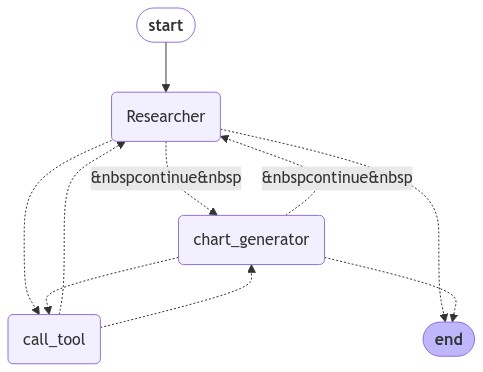

In [16]:
# 可视化图
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception as e:
    print(f"Error generating graph: {e}")


### 执行图

接下来我们将使用多智能体，生成一些统计图表。

================================ Human Message =================================

Obtain the GDP of the United States from 2000 to 2020, and then plot a line chart with Python. End the task after generating the chart。
================================== Ai Message ==================================
Name: Researcher
Tool Calls:
  tavily_search_results_json (call_szF5k9Dm2jD3pskuXOtinlbT)
 Call ID: call_szF5k9Dm2jD3pskuXOtinlbT
  Args:
    query: United States GDP from 2000 to 2020
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.statista.com/topics/772/gdp/", "content": "U.S. gross domestic product contributions 2000-2021, by sector\nValue added to gross domestic product across economic sectors in the United States from 2000 to 2021 (as a share of GDP)\nU.S. change in real value added to GDP 2022, by industry\nChange in real value added to the gross domestic product of the United States in 2022, by in

Python REPL can execute arbitrary code. Use with caution.


================================== Ai Message ==================================
Name: chart_generator
Tool Calls:
  python_repl (call_rRsdqFLGml3J2tjj2K1jWQp8)
 Call ID: call_rRsdqFLGml3J2tjj2K1jWQp8
  Args:
    code: import matplotlib.pyplot as plt

# Sample GDP data
years = list(range(2000, 2021))
gdp_values = [10.25, 10.58, 10.64, 10.91, 11.24, 11.66, 12.09, 
              12.56, 12.53, 12.11, 12.55, 12.99, 13.09, 
              13.38, 14.25, 16.12, 16.66, 17.19, 18.57, 
              21.43, 21.43]

# Plotting the GDP data
plt.figure(figsize=(10, 5))
plt.plot(years, gdp_values, marker='o')
plt.title('GDP of the United States (2000-2020)')
plt.xlabel('Year')
plt.ylabel('GDP (Trillions of USD)')
plt.grid()
plt.xticks(years, rotation=45)
plt.tight_layout()

# Show the plot
plt.show()


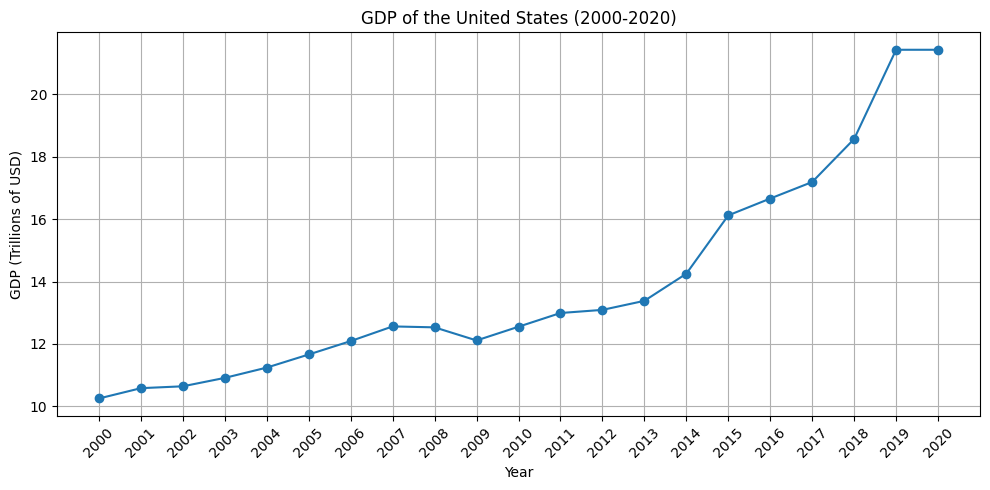

================================= Tool Message =================================
Name: python_repl

Successfully executed:
```python
import matplotlib.pyplot as plt

# Sample GDP data
years = list(range(2000, 2021))
gdp_values = [10.25, 10.58, 10.64, 10.91, 11.24, 11.66, 12.09, 
              12.56, 12.53, 12.11, 12.55, 12.99, 13.09, 
              13.38, 14.25, 16.12, 16.66, 17.19, 18.57, 
              21.43, 21.43]

# Plotting the GDP data
plt.figure(figsize=(10, 5))
plt.plot(years, gdp_values, marker='o')
plt.title('GDP of the United States (2000-2020)')
plt.xlabel('Year')
plt.ylabel('GDP (Trillions of USD)')
plt.grid()
plt.xticks(years, rotation=45)
plt.tight_layout()

# Show the plot
plt.show()
```
Stdout: 

If you have completed all tasks, respond with FINAL ANSWER.
================================== Ai Message ==================================
Name: chart_generator

FINAL ANSWER: The line chart of the GDP of the United States from 2000 to 2020 has been successfully generated. 

In [17]:
events = graph.stream(
    {
        "messages": [
            HumanMessage(
                content="Obtain the GDP of the United States from 2000 to 2020, "
            "and then plot a line chart with Python. End the task after generating the chart。"
            )
        ],
    },
    # 设置最大递归限制
    {"recursion_limit": 20},
    stream_mode="values"
)

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()  # 打印消息内容


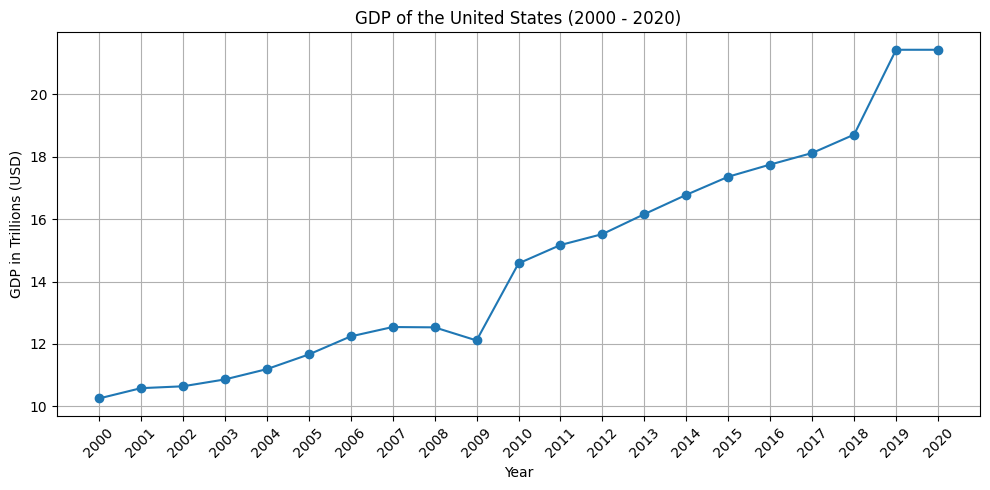

In [18]:
import matplotlib.pyplot as plt

# Years and corresponding GDP values
years = list(range(2000, 2021))
gdp_values = [
    10.25, 10.58, 10.64, 10.86, 11.19, 
    11.66, 12.24, 12.54, 12.53, 12.11, 
    14.58, 15.17, 15.52, 16.16, 16.78, 
    17.36, 17.75, 18.12, 18.71, 21.43, 
    21.43
]

# Plotting the GDP data
plt.figure(figsize=(10, 5))
plt.plot(years, gdp_values, marker='o')
plt.title('GDP of the United States (2000 - 2020)')
plt.xlabel('Year')
plt.ylabel('GDP in Trillions (USD)')
plt.xticks(years, rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

## Homework

1. 使用不同的大模型运行多智能体，对比结果并评选 `gpt-4o` 之下最好的大模型，将所有的大模型和最终结果生成一张表格；
2. 将 `chart_generator` 替换为其他功能智能体（如 `table_generator`），为其设计提示词，然后运行查看生成结果。

## GPT-4o 模型生成结果

================================ Human Message =================================

Obtain the GDP of the United States from 2000 to 2020, and then plot a line chart with Python. End the task after generating the chart。
================================== Ai Message ==================================
Name: Researcher
Tool Calls:
  tavily_search_results_json (call_4NIjUy0nWiYo8qN3BF0yZzwx)
 Call ID: call_4NIjUy0nWiYo8qN3BF0yZzwx
  Args:
    query: United States GDP from 2000 to 2020
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.statista.com/topics/772/gdp/", "content": "U.S. gross domestic product contributions 2000-2021, by sector\nValue added to gross domestic product across economic sectors in the United States from 2000 to 2021 (as a share of GDP)\nU.S. change in real value added to GDP 2022, by industry\nChange in real value added to the gross domestic product of the United States in 2022, by in

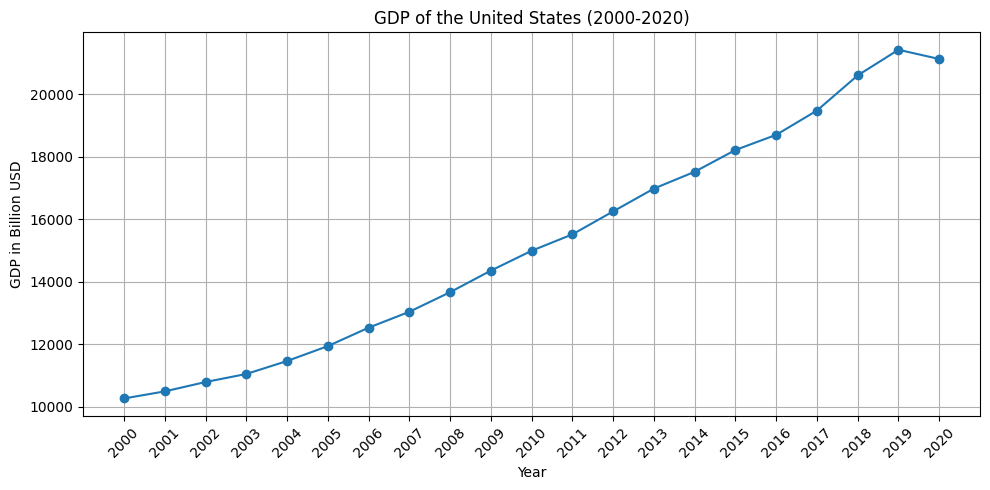

================================= Tool Message =================================
Name: python_repl

Successfully executed:
```python
import matplotlib.pyplot as plt

# Sample GDP data (in billions USD) from 2000 to 2020
years = list(range(2000, 2021))
gdp_values = [10258, 10485, 10785, 11043, 11458, 11936,
    12526, 13036, 13664, 14355, 14992, 15517,
    16253, 16984, 17523, 18221, 18707, 19485,
    20612, 21433, 21137]  # Note: GDP for 2020 is affected by COVID-19

# Plotting the GDP data
plt.figure(figsize=(10, 5))
plt.plot(years, gdp_values, marker='o')
plt.title('GDP of the United States (2000-2020)')
plt.xlabel('Year')
plt.ylabel('GDP in Billion USD')
plt.xticks(years, rotation=45)
plt.grid()
plt.tight_layout()
plt.show()
```
Stdout: 

If you have completed all tasks, respond with FINAL ANSWER.
================================== Ai Message ==================================
Name: chart_generator

FINAL ANSWER: The line chart displaying the GDP of the United States from 2000 to 20

In [19]:
events = graph.stream(
    {
        "messages": [
            HumanMessage(
                content="Obtain the GDP of the United States from 2000 to 2020, "
            "and then plot a line chart with Python. End the task after generating the chart。"
            )
        ],
    },
    # 设置最大递归限制
    {"recursion_limit": 20},
    stream_mode="values"
)

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()  # 打印消息内容
